In [92]:
%matplotlib inline
from netCDF4 import Dataset as ncread
import netCDF4 as nc
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
import pandas as pd
from datetime import datetime
from itertools import product
from cftime import DatetimeNoLeap
import xarray as xr

In [93]:
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
import matplotlib.path as mpath

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle

In [95]:
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

## Data set

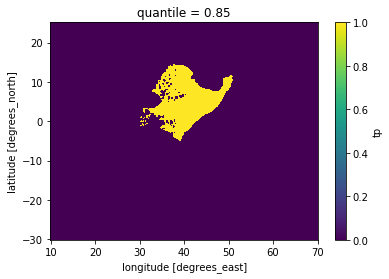

In [96]:
#Check the regional mask original file
root_data = '/data/volume_2/observational/'
root_results = '/home/mpyrina/Lorentz_workshop/Results/'

file = 'era5_hoa_dry_mask_0.25deg.nc' #0.25

mask=xr.open_mfdataset(root_data+file,combine='by_coords',parallel=True)
mask.tp.plot()

Frozen(SortedKeysDict({'latitude': 28, 'longitude': 31}))

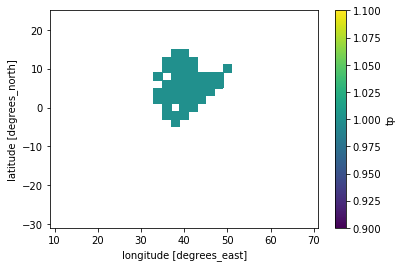

In [97]:
#Check the regional mask interpolated file
root_data = '/data/volume_2/observational/'
root_results = '/home/mpyrina/Lorentz_workshop/Results/'

file = 'era5_hoa_dry_mask_2deg.nc' #0.25

mask=xr.open_mfdataset(root_data+file,combine='by_coords',parallel=True)
mask_nan=mask.where(mask==1) #keep the values==1 and mask the rest
mask_nan.tp.plot()
mask_nan.sizes

#### Prepare target 
#### define drought events when 31-day running mean rainfall in OND from 1980-2021 is below the 33rd percentile, the tercile is calculated based on the 2000-2020 period

In [98]:
# Create time series of target data for the area_mean

file=xr.open_mfdataset(root_data+f'/raw/era5_tp_1959-2021_1_12_daily_2.0deg.nc',
                          combine='by_coords',parallel=True)
tp_dim=file.sel(longitude=slice(10,70),latitude=slice(24,-30))
tp_series=np.multiply(mask_nan,tp_dim).mean(dim='latitude',skipna=True).mean(dim='longitude',skipna=True)

# Calculate daily terciles based on a 31 day rolling and select OND 2000-2020 data to decide the quantile threshold
tp_rol=tp_series.rolling(time=31, center=True).mean().sel(time=tp_series.time.dt.year.isin([np.arange(2000,2021)]))
tp_quantile=tp_rol.sel(time=tp_rol.time.dt.month.isin([10,11,12])).quantile(0.33)

In [99]:
#MAsk the time series with the percentile and create index time series from 1980-2021
tp_rol = tp_series.rolling(time=31, center=True).mean().sel(time=tp_series.time.dt.month.isin([10,11,12]))
tp_rol_sel = tp_rol.sel(time = slice('1980','2021'))
tp_index = tp_rol_sel < tp_quantile
tp_index = tp_index.astype(int)

#tp_index=tp_rol_sel.where(tp_rol_sel<tp_quantile['tp'].values)
#tp_index_1=tp_index['tp'].values
#tp_index_1[np.where(~np.isnan(tp_index_1))]=1
#tp_index_1[np.where(np.isnan(tp_index_1))]=0
#tp_ind_1=np.where((tp_index['tp'].values)==np.isnan,1,0)

In [100]:
# prediction from Oct 15 to Dec 15
for iyr in range(1980,2022):
    if iyr == 1980:
        tp_target = tp_index.sel(time = slice(str(iyr)+'-10-16',str(iyr)+'-12-16'))
    else:
        tp_target = xr.concat([tp_target,tp_index.sel(time = slice(str(iyr)+'-10-16',str(iyr)+'-12-16'))], dim='time')
print('number of 0 and 1: ',np.unique(tp_target['tp'],return_counts=True))
tp_target

number of 0 and 1:  (array([0, 1]), array([1939,  665]))


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


<xarray.Dataset>
Dimensions:   (time: 2604)
Coordinates:
    quantile  float64 0.33
  * time      (time) datetime64[ns] 1980-10-16 1980-10-17 ... 2021-12-16
Data variables:
    tp        (time) int64 dask.array<chunksize=(62,), meta=np.ndarray>

#### Prepare predictors: 30 days time series with the last day two weeks before the target day

In [101]:
from datetime import datetime 
from datetime import timedelta
from datetime import date

In [102]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")

In [103]:
# TP Predictor
tp_predictor_series = tp_series.sel(time=tp_series.time.dt.year.isin([np.arange(1980,2022)])).rolling(time=7, center=False).mean()
YYY = 1980
MMM = 10
DDD = 16
# 31-day running mean so 15 days before the central day + 2 weeks in advance + 7-day running mean + 30-day time steps
date_target = datetime.strftime(datetime(year=YYY,month=MMM,day=DDD), "%Y.%m.%d")
tp_predictor = np.ndarray((len(tp_target['tp']),30))
it = 0
ii = 0
while YYY < 2022:
    date_start = datetime.strftime(datetime.strptime(date_target, "%Y.%m.%d")-timedelta(days=15+14+7+30-1),"%Y.%m.%d")
    date_end = datetime.strftime(datetime.strptime(date_target, "%Y.%m.%d")-timedelta(days=15+14+7),"%Y.%m.%d")
    #print(date_target,date_start,date_end,it)
    tp_predictor[ii,:] = tp_predictor_series.sel(time = slice(date_start,date_end))['tp']
    if date_target == datetime.strftime(datetime(year=YYY,month=12,day=16),"%Y.%m.%d"):
        YYY = YYY+1
        date_target = datetime.strftime(datetime(year=YYY,month=MMM,day=DDD), "%Y.%m.%d")
        it = 0
        print(YYY)
    else:
        it = 1
    ii = ii+1
    date_target = datetime.strftime(datetime.strptime(date_target, "%Y.%m.%d")+timedelta(days=it),"%Y.%m.%d") 

1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


## LSTM with attention layer

In [104]:
# https://github.com/gentaiscool/lstm-attention/blob/58adc7e345b5b3a79638483049704802a66aa1f4/layers.py#L50
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    follows these equations:
    
    (1) u_t = tanh(W h_t + b)
    (2) \alpha_t = \frac{exp(u^T u)}{\sum_t(exp(u_t^T u))}, this is the attention weight
    (3) v_t = \alpha_t * h_t, v in time t
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        3D tensor with shape: `(samples, steps, features)`.
    """

    def __init__(self,
                W_regularizer=None, u_regularizer=None, b_regularizer=None,
                W_constraint=None, u_constraint=None, b_constraint=None,
                bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'W_regularizer': self.W_regularizer,
                'u_regularizer': self.u_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'u_constraint': self.u_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                initializer=self.init,
                                name='{}_W'.format(self.name),
                                regularizer=self.W_regularizer,
                                constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                    initializer='zero',
                                    name='{}_b'.format(self.name),
                                    regularizer=self.b_regularizer,
                                    constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                initializer=self.init,
                                name='{}_u'.format(self.name),
                                regularizer=self.u_regularizer,
                                constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero and this results in NaN's. 
        # Should add a small epsilon as the workaround
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        
        return weighted_input

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2]
    
class Addition(Layer):
    """
    This layer is supposed to add of all activation weight.
    We split this from AttentionWithContext to help us getting the activation weights
    follows this equation:
    (1) v = \sum_t(\alpha_t * h_t)
    
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    """

    def __init__(self, **kwargs):
        super(Addition, self).__init__(**kwargs)

    def build(self, input_shape):
        self.output_dim = input_shape[-1]
        super(Addition, self).build(input_shape)

    def call(self, x):
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [105]:
# LSTM with attention layer
ntimestep = 30    # number of time step used in the predictors
nfeature = 1   # number of features
input_tensor = Input(shape=(ntimestep,nfeature))
layer1 = layers.LSTM(30, return_sequences=True)(input_tensor)
layer1 = layers.LSTM(10, return_sequences=True)(layer1)
layer1 = AttentionWithContext()(layer1)
layer1 = Addition()(layer1)
layer1 = layers.Dense(10, activation="relu")(layer1)
output_tensor = layers.Dense(2,activation='softmax')(layer1)

callbacks_path = '/net/cfc/s2s/zhengwu/code/tmp/checkpoint_test'
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=callbacks_path,
        monitor='val_acc',
        save_best_only=True,
    )
]
model = Model(input_tensor, output_tensor)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 10)            1640      
_________________________________________________________________
attention_with_context_6 (At (None, 30, 10)            120       
_________________________________________________________________
addition_6 (Addition)        (None, 10)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_13 (Dense)             (None, 2)               

## Splitting the data

In [106]:
def get_train_test_val(data_predictor, data_target, test_frac, val_frac):
    """Splits data across periods into train, test, and validation"""
    # assign the last int(-test_frac*len(tp_predictor)) rows to test data
    test_predictor = data_predictor[int(-test_frac*len(tp_predictor)):]
    test_target = data_target[int(-test_frac*len(tp_predictor)):]
    
    # assign the last int(-test_frac*len(tp_predictor)) from the remaining rows to validation data
    remain_predictor = data_predictor[0:int(-test_frac*len(tp_predictor))]
    remain_target = data_target[0:int(-test_frac*len(tp_predictor))]
    val_predictor = remain_predictor[int(-val_frac*len(remain_predictor)):]
    val_target = remain_target[int(-val_frac*len(remain_predictor)):]
    
    # the remaining rows are assigned to train data
    train_predictor = remain_predictor[:int(-val_frac*len(remain_predictor))]
    train_target = remain_target[:int(-val_frac*len(remain_predictor))]
    return train_predictor, train_target, test_predictor, test_target, val_predictor, val_target

tp_target = tp_target['tp'].values
tp_target = keras.utils.to_categorical(tp_target)
tp_predictor = tp_predictor[..., np.newaxis]
print(tp_predictor.shape,tp_target.shape)
train_predictor, train_target, test_predictor, test_target, val_predictor, val_target = get_train_test_val(tp_predictor, tp_target, test_frac=0.3, val_frac=0.2)

(2604, 30, 1) (2604, 2)


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


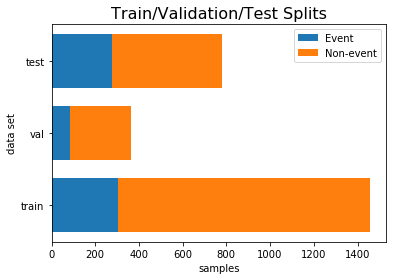

In [107]:
ind = [0, 1, 2]
names = ["train", "val", "test"]
width = 0.75
event_cnts = [np.unique(train_target[:,1],return_counts=True)[1][1],np.unique(val_target[:,1],return_counts=True)[1][1],np.unique(test_target[:,1],return_counts=True)[1][1]]
nonevent_cnts = [np.unique(train_target[:,1],return_counts=True)[1][0],np.unique(val_target[:,1],return_counts=True)[1][0],np.unique(test_target[:,1],return_counts=True)[1][0]]

p1 = plt.barh(ind, event_cnts, width)
p2 = plt.barh(ind, nonevent_cnts, width, left=event_cnts)

plt.yticks(ind, names)
plt.ylabel("data set")
plt.xlabel("samples")
plt.title("Train/Validation/Test Splits", fontsize=16)
plt.legend(["Event", "Non-event"])

In [108]:
batch_size = 32
epochs = 10
shuffle = False 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [109]:
callbacks_path = '/home/zwu/Lorentz_workshop/test/checkpoint_test'
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=callbacks_path,
        monitor='val_accuracy',
        save_best_only=True,
    )
]

In [110]:
history = model.fit(train_predictor, train_target, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(val_predictor, val_target), verbose=verbose)

Epoch 1/10
INFO:tensorflow:Assets written to: /home/zwu/Lorentz_workshop/test/checkpoint_test/assets
46/46 - 6s - loss: 0.5824 - accuracy: 0.7889 - val_loss: 0.5589 - val_accuracy: 0.7692
Epoch 2/10
46/46 - 1s - loss: 0.5137 - accuracy: 0.7916 - val_loss: 0.5411 - val_accuracy: 0.7692
Epoch 3/10
46/46 - 1s - loss: 0.5130 - accuracy: 0.7916 - val_loss: 0.5418 - val_accuracy: 0.7692
Epoch 4/10
46/46 - 1s - loss: 0.5140 - accuracy: 0.7916 - val_loss: 0.5402 - val_accuracy: 0.7692
Epoch 5/10
46/46 - 1s - loss: 0.5130 - accuracy: 0.7916 - val_loss: 0.5418 - val_accuracy: 0.7692
Epoch 6/10
46/46 - 1s - loss: 0.5126 - accuracy: 0.7916 - val_loss: 0.5408 - val_accuracy: 0.7692
Epoch 7/10
46/46 - 1s - loss: 0.5130 - accuracy: 0.7916 - val_loss: 0.5421 - val_accuracy: 0.7692
Epoch 8/10
46/46 - 1s - loss: 0.5123 - accuracy: 0.7916 - val_loss: 0.5420 - val_accuracy: 0.7692
Epoch 9/10
46/46 - 1s - loss: 0.5122 - accuracy: 0.7916 - val_loss: 0.5411 - val_accuracy: 0.7692
Epoch 10/10
46/46 - 1s - los

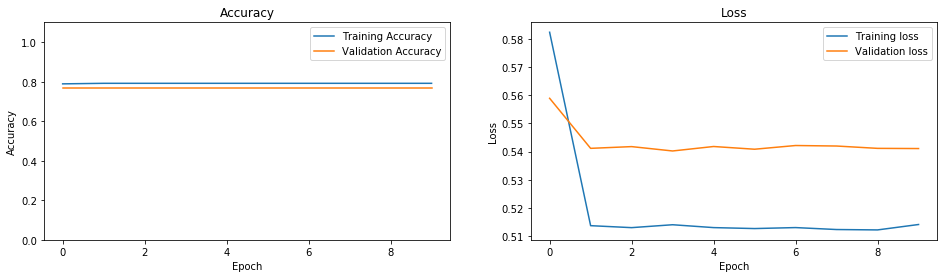

In [111]:
# plot learning curve
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0,1.1)
ax1.legend()

ax2.plot(train_loss, label='Training loss')
ax2.plot(val_loss, label='Validation loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

In [115]:
# evaluation
test_predict = model.predict(test_predictor)

In [88]:
# output attention weights 
layer_weights = model.layers[3].get_weights()

# extract layer output before the attention layer
new_model = Model(inputs=model.input, outputs=model.layers[2].output)
output_before_att = new_model.predict(test_predictor)
print(type(output_before_att),np.shape(output_before_att))

# weights from Yang et al. (2016) HAN
uit = np.tanh(np.dot(output_before_att, layer_weights[0]) + layer_weights[1]) 
eij = np.dot(uit, layer_weights[2])
print(uit.shape,eij.shape)
eij = eij.reshape((eij.shape[0], eij.shape[1]))
print(eij.shape)
ai = np.exp(eij)
weights = np.ndarray((len(ai),ntimestep))+np.nan
for ii in range(len(ai)):
    weights[ii,:] = ai[ii,:] / np.sum(ai[ii,:])
print(ai.shape,weights.shape)

<class 'numpy.ndarray'> (781, 30, 10)
(781, 30, 10) (781, 30)
(781, 30)
(781, 30) (781, 30)


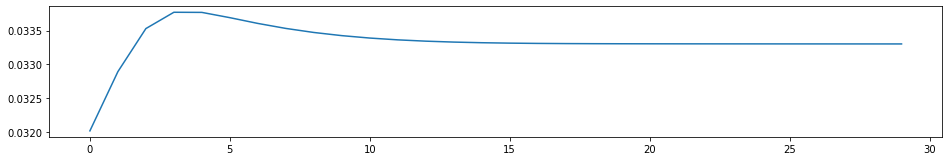

In [91]:
weights_norm = weights/np.nanmax(weights, axis=(-1))[:,np.newaxis]
fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(np.mean(weights,axis=0))